# Ensemble Algorithms<br>
Up until this point, we used only one algorithm per model, but what if we could combine multiple models to get an even better result. Those algorithms are called <b>ensemble algorithms</b>.The first example that pops in our heads is a musical ensemble. By combining multiple different instruments, we get one perfect symphony.<br>
Same goes for machine learning. We combine multiple models we previously learned into one model which can give us even better results.<br><br>
Marquis de Condorcet introduced his jury theorem, which was based on the idea that multiple jurors (models) could better predict the final result than separately. "If each member of the jury makes an independent judgement and the probability of the correct decision by each juror is more than 0.5, then the probability of the correct decision by the whole jury increases with the total number of jurors and tends to one. On the other hand, if the probability of being right is less than 0.5 for each juror, then the probability of the correct decision by the whole jury decreases with the number of jurors and tends to zero."<br><br>
<b>Voting</b><br><br>
Voting classifiers are classifiers which implement Condorcet's jury theorem. The final prediction is decided by the majority.<br>
There are two types of voting, `soft` which uses probabilities of the models, and `hard` which uses final predictions (ex. 0s and 1s).

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/churn.csv')

In [2]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X.set_index(['Phone'], inplace=True)

X['Int\'l Plan'] = X['Int\'l Plan'].map({'no': 0, 'yes': 1})
X['VMail Plan'] = X['VMail Plan'].map({'no': 0, 'yes': 1})

X = pd.get_dummies(X, columns=['State', 'Area Code'])

X.head()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,...,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510
Phone,,,,,,,,,,,,,,,,,,,,,
382-4657,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,0,0,0,0,0,0,0,0,1,0
371-7191,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,0,0,0,0,0,0,0,0,1,0
358-1921,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,0,0,0,0,0,0,0,0,1,0
375-9999,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,0,0,0,0,0,0,0,1,0,0
330-6626,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,0,0,0,0,0,0,0,0,1,0


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score

model_tree = DecisionTreeClassifier()
model_lr = LogisticRegression()
model = VotingClassifier(voting='soft', estimators=[('tree', model_tree), ('lr', model_lr)])

In [4]:
for model, label in zip([model_tree, model_lr, model], ['Tree', 'LR', 'Voting']):
    scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
    print(f'{label}: {scores.mean()}')

Tree: 0.8281482724668814
LR: 0.8081047857739587
Voting: 0.8897718999880653


## Bagging<br>
Bagging (bootstrap aggregation) is an ensemble approach which uses existing instances to create new, similar but different instances. Each instance can be resampled multiple times. After this process, we have multiple subsets of new instances and we use models for predictions on each of the new subsets.<br>
<img src='img/bagging.jpeg'>

In [10]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(base_estimator=model_tree, bootstrap=10, 
                          max_samples=0.5, max_features=40)

scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
scores.mean()

0.89375082050364

One famous algorithm which is based on bagging is called Random Forest. What is surprising, it uses Decision Tree as it's base model.<br>
Another neat functionality of Random Forest is `feature importance` which returns the importance of each feature on the final prediction.<br><br>
Some of the more important hyperparameters of the Random Forest algorithm are:
1. `n_estimators` - number of Decision Trees used
2. `max_features` - the maximum number of features used by each Decision Tree (these are taken randomly)
3. `max_depth` - the depth of each Decision Tree, same as in single Decision Trees
4. `criterion` - a function used to measure the quality of a split in a Decision Tree

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

scores = cross_val_score(model, X, y, cv = 10, scoring='roc_auc')
scores.mean()

0.9105693549349564

Now we can plot feature importances and see how much they affect the final predictions.

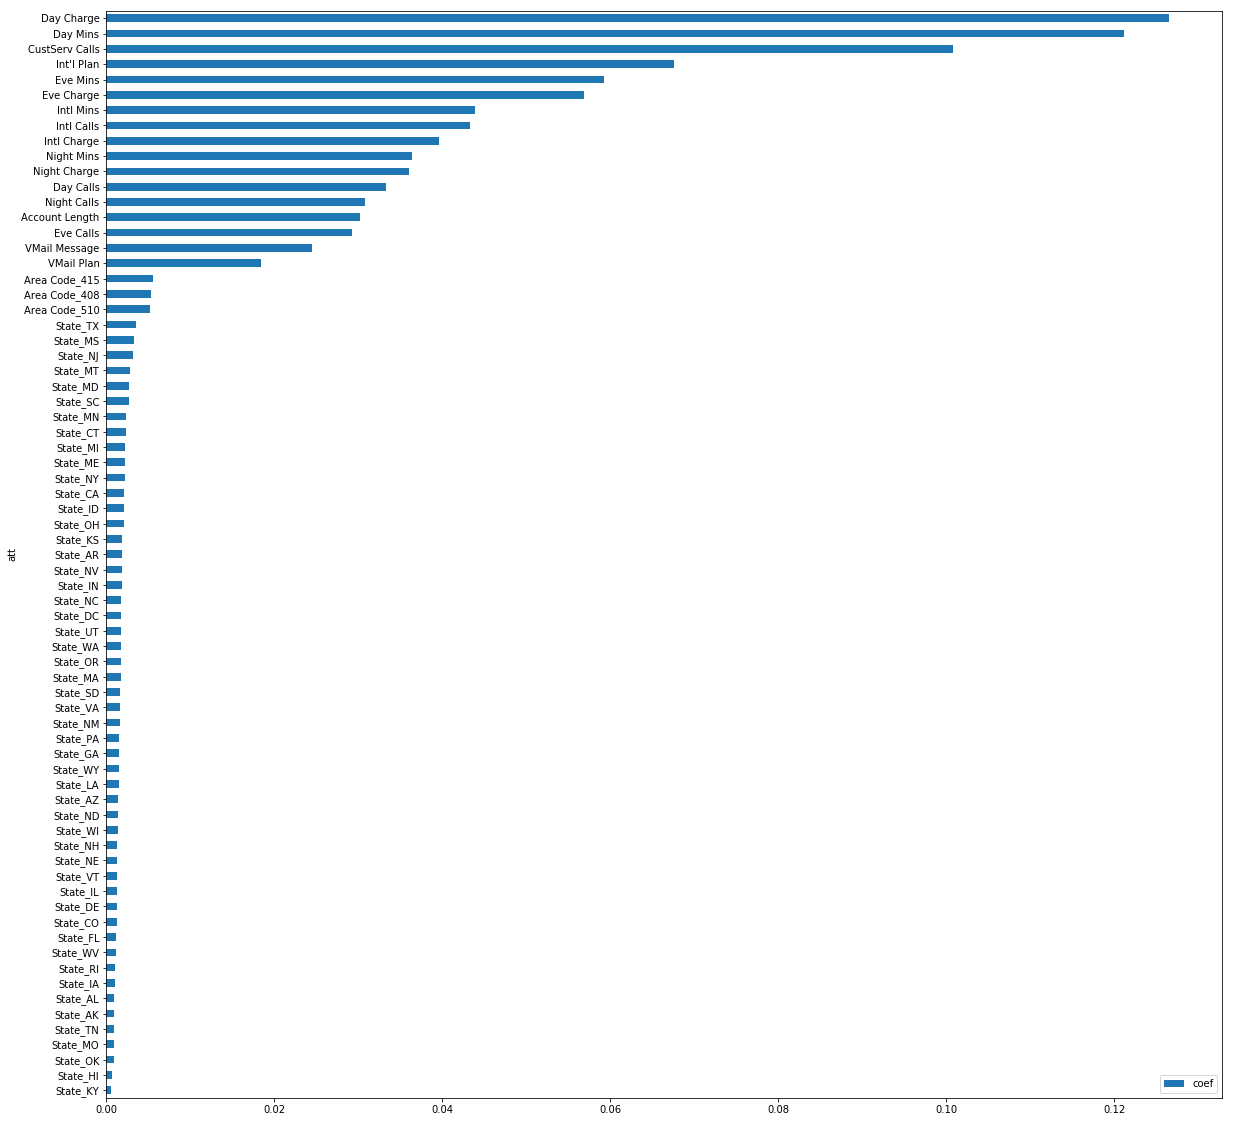

In [12]:
import seaborn as sns
%matplotlib inline

model.fit(X, y)

coefs = pd.DataFrame({'att':X.columns, 'coef':model.feature_importances_}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.replace(0,np.nan).dropna().plot.barh(x='att',y='coef',figsize=(20, 20))

## Boosting<br>
Boosting is a very powerful ensemble approach which can be described very simply, in just 4 steps:<br>
1. Learn a model
2. Subset the instances model predicted wrongly
3. Increase the importance of said subset
4. Repeat steps 1-3

The following algorithm is called Adaptive Boosting or AdaBoost for short and it does what we previously explained.

In [13]:
from sklearn.ensemble import AdaBoostClassifier

model_tree = DecisionTreeClassifier()

model_boost = AdaBoostClassifier(base_estimator=model_tree, n_estimators=50)

scores = cross_val_score(model, X, y, cv = 10, scoring='roc_auc')
scores.mean()

0.916421410669531

One of the most powerful algorithms in this category is <b>Gradient Boosting Tree</b>, which is one of the most popular algorithms used by the winning teams in data competitions and datathons.<br>
Some of the hyperparameters used are:<br>
1. `learning_rate` - shrinks the contribution of each tree
2. `n_estimators` - number of trees (boosting steps) to perform
3. `subsample` - the percentage of examples to use for learning
4. `max_depth` - the depth of the tree
5. and other Decision Tree hyperparameters

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100)

scores = cross_val_score(model, X, y, cv = 10, scoring='roc_auc')
scores.mean()

0.9152959780403389

## Additional Resources<br>
1. Ensemble methods on sklearn <a href='https://scikit-learn.org/stable/modules/ensemble.html#ensemble'>documentation page</a>
2. Original <a href='https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf'>paper</a> on Random Forests
3. Chapter 15 of the book <a href='https://web.stanford.edu/~hastie/ElemStatLearn//'>“Elements of Statistical Learning”</a> by Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie could prove useful
4. Excellent in-depth <a href='https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205'>article</a> on TowardsDataScience about Bagging, Boosting and Stacking and some of the algorithms we used